# Multi Layer Perceptron

In [1]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
!pip install --upgrade pandas scikit-learn seaborn pyarrow

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.models import Model


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Carregando os dados

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_all = pd.read_parquet("/content/drive/MyDrive/capture24/Participants_all.parquet")

In [7]:
df_all.head()

,pid,window_start,window_end,n_samples,duration_seconds,sex,age_group,label:Walmsley2020,label:Walmsley2020_enc,label:WillettsSpecific2018,label:WillettsSpecific2018_enc,label:WillettsMET2018,label:WillettsMET2018_enc,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max,energy_x,energy_y,energy_z,energy_total,magnitude_mean,corr_xy,corr_xz,corr_yz,fft_dom_freq,fft_peak_power,hour_sin,hour_cos
0,P001,2016-11-13 02:18:00,2016-11-13 02:18:05,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.468161,0.004565,-0.482334,-0.46669,-0.537512,0.006892,-0.548902,-0.533341,0.657518,0.003960,0.643077,0.673867,0.219195,0.288966,0.432345,0.940507,0.969787,-0.148480,-0.077644,0.275487,0.0,0.0,0.566406,0.824126
1,P001,2016-11-13 02:18:05,2016-11-13 02:18:10,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.470069,0.006437,-0.482334,-0.46669,-0.537045,0.006771,-0.548902,-0.517780,0.657702,0.003627,0.643077,0.673867,0.221007,0.288463,0.432585,0.942055,0.970582,-0.108382,-0.028882,0.137541,0.0,0.0,0.566706,0.823920
2,P001,2016-11-13 02:18:10,2016-11-13 02:18:15,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.469694,0.006162,-0.482334,-0.46669,-0.537947,0.007104,-0.548902,-0.533341,0.657764,0.003369,0.643077,0.673867,0.220650,0.289438,0.432665,0.942753,0.970944,-0.260468,-0.079268,0.204062,0.0,0.0,0.567005,0.823714
3,P001,2016-11-13 02:18:15,2016-11-13 02:18:20,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.469287,0.005821,-0.482334,-0.46669,-0.537512,0.006962,-0.548902,-0.517780,0.657733,0.003567,0.643077,0.673867,0.220264,0.288967,0.432626,0.941857,0.970483,-0.243211,-0.092415,0.223157,0.0,0.0,0.567305,0.823508
4,P001,2016-11-13 02:18:20,2016-11-13 02:18:25,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.470820,0.006896,-0.482334,-0.46669,-0.535333,0.005291,-0.548902,-0.517780,0.658226,0.002743,0.643077,0.673867,0.221719,0.286609,0.433269,0.941597,0.970350,-0.225457,-0.079250,0.230302,0.0,0.0,0.567604,0.823302


In [8]:
df_all.shape

(1843551, 37)

In [9]:
# coluna da atividade alvo
TARGET = "label:WillettsSpecific2018"

In [10]:
label2enc = (
    df_all[["label:WillettsSpecific2018","label:WillettsSpecific2018_enc"]]
    .drop_duplicates()
    .set_index("label:WillettsSpecific2018")["label:WillettsSpecific2018_enc"]
    .sort_index()
    .to_dict()
)

In [11]:
enc2label = {
    v: k for k, v in label2enc.items()
}

## Preparação do Data Set Para o MLP
Separação de treino e teste

Verficação de Nas

Pre-processamento: one hot-encoding, standard scaling

### Separação em treino e teste

In [12]:
#features baseadas em aceleração
features_acc = [
    'x_mean', 'x_std','x_min', 'x_max',
    'y_mean', 'y_std', 'y_min', 'y_max',
    'z_mean','z_std', 'z_min', 'z_max',
    'energy_x', 'energy_y', 'energy_z','energy_total',
    'magnitude_mean', 'corr_xy', 'corr_xz', 'corr_yz',
    'fft_dom_freq', 'fft_peak_power'
]


#features de contexto, não baseadas em aceleração.
features_cont = ['sex', 'age_group', 'hour_sin', 'hour_cos']

In [13]:
cols_corr = ["corr_xy", "corr_xz", "corr_yz"]
df_all[cols_corr] = df_all[cols_corr].fillna(0)

### Conforme decisão na primeira versão do notebook MLP_Model vamos retirar P043 para teste

In [14]:
df_all_test = df_all[df_all['pid']=='P043'].reset_index(drop=True)
df_all_train = df_all[df_all['pid']!='P043'].reset_index(drop=True)

In [18]:
#target
y_train = df_all_train['label:WillettsSpecific2018_enc']
y_test = df_all_test['label:WillettsSpecific2018_enc']

#features apenas com variáveis numéricas de aceleração (22 features)
X_acc_train= df_all_train[features_acc]
X_acc_test= df_all_test[features_acc]

#features com variáveis numéricas de aceleração e features de contexto (26 features)
X_all_train = df_all_train[features_acc+features_cont]
X_all_test = df_all_test[features_acc+features_cont]

### Pre-processamento: standard scaling + one hot-encoding

In [15]:
def build_preprocessor(X_train):
    '''sex não é escalado → mantido como 0/1
    age_group é one-hot
    numeric_features recebem scaler
    ordem das colunas é garantida'''

    # 1. Definir grupos de features
    categorical_features = ["age_group"] if "age_group" in X_train.columns else []

    # variáveis que NÃO devem ser transformadas (mantidas como estão)
    passthrough_features = []
    if "sex" in X_train.columns:
        passthrough_features.append("sex")

    # numéricas contínuas = todas as outras
    numeric_features = [
        col for col in X_train.columns
        if col not in categorical_features + passthrough_features
    ]

    # 2. Transformadores
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    )

    # 3. ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
            ("pass", "passthrough", passthrough_features),
        ],
        remainder="drop"
    )

    # 4. Fit no treino
    preprocessor.fit(X_train)

    # 5. Construção correta dos nomes finais
    # numéricas escaladas
    out_num = numeric_features

    # categorias one-hot
    out_cat = (
        preprocessor.named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
        .tolist()
        if categorical_features else []
    )

    # binárias mantidas (sexo)
    out_pass = passthrough_features

    feature_names = out_num + out_cat + out_pass

    return preprocessor, feature_names

In [16]:
def apply_preprocessor(preprocessor, X, feature_names):
    X_trans = preprocessor.transform(X)
    return pd.DataFrame(X_trans, columns=feature_names, index=X.index)

### V1 — só aceleração

In [19]:
prep_v1, feat_v1 = build_preprocessor(X_acc_train)
X_v1_train = apply_preprocessor(prep_v1, X_acc_train, feat_v1)
X_v1_test  = apply_preprocessor(prep_v1, X_acc_test, feat_v1)

### V2 — aceleração + contexto

In [20]:
prep_v2, feat_v2 = build_preprocessor(X_all_train)
X_v2_train = apply_preprocessor(prep_v2, X_all_train, feat_v2)
X_v2_test  = apply_preprocessor(prep_v2, X_all_test, feat_v2)

## MLP

### Duas possíveis arquiteturas

In [21]:
#Versão mais robusta para rodar no colab

def residual_block(x, units, l2=1e-4, dropout_rate=0.3):
    shortcut = x  # caminho residual

    # Dense → BN → ReLU
    x = layers.Dense(units, kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Dense → BN  (sem ReLU antes do sum)
    x = layers.Dense(units, kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)

    # soma residual
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x




def build_mlp_baseline(n_features, n_classes):
    inputs = layers.Input(shape=(n_features,))
    x = layers.Dense(256)(inputs)

    # === Residual block 256 ===
    x = residual_block(x, units=256, dropout_rate=0.4)

    # === Projeta para 128 ===
    x = layers.Dense(128)(x)

    # === Residual block 128 ===
    x = residual_block(x, units=128, dropout_rate=0.3)

    # === Projeta para 64 ===
    x = layers.Dense(64)(x)

    # === Residual block 64 ===
    x = residual_block(x, units=64, dropout_rate=0.2)

    outputs = layers.Dense(n_classes, activation='softmax')(x)
    return Model(inputs, outputs)

In [ ]:
#Versão mais leve para V1
def build_mlp_light(n_features, n_classes):
    model = models.Sequential()

    model.add(layers.Dense(128, input_shape=(n_features,), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(32, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

### Compilador

In [22]:
def compile_mlp_v1_optimized(model, lr=1e-3, smoothing=0.05):
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=smoothing),
        metrics=['accuracy']
    )
    return model

### Critérios a serem usados no fit

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [25]:
cw_raw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), cw_raw)}

In [26]:
for cls in class_weights:
    if class_weights[cls] > np.median(cw_raw):
        class_weights[cls] *= 1.3     # aumenta só 30% nas raras

### Rodar no google colab apenas com variáveis de aceleração e arquitetura light

In [27]:
n_features = X_v1_train.shape[1] #X_v1_train ou X_v2_train
X_train_tensor = X_v1_train.to_numpy().astype(np.float32)

n_classes = 10
y_train_onehot = to_categorical(y_train, num_classes=n_classes)


In [28]:
model = build_mlp_baseline(n_features, n_classes)  # build_mlp_light ou build_mlp_baseline
model = compile_mlp_v1_optimized(model, lr=1e-3)

### Primeiro treino

In [29]:
history = model.fit(
    X_train_tensor,
    y_train_onehot,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1
)

Epoch 1/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.4868 - loss: 1.9064 - val_accuracy: 0.5165 - val_loss: 1.5225
Epoch 2/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.5707 - loss: 1.6418 - val_accuracy: 0.5427 - val_loss: 1.4555
Epoch 3/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.5974 - loss: 1.5477 - val_accuracy: 0.5575 - val_loss: 1.4173
Epoch 4/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.6095 - loss: 1.5017 - val_accuracy: 0.5650 - val_loss: 1.4115
Epoch 5/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.6173 - loss: 1.4736 - val_accuracy: 0.5141 - val_loss: 1.5251
Epoch 6/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.6245 - loss: 1.4486 - val_accuracy: 0.5459 - val_loss: 1.4432
Epoch 7/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.6283 - loss: 1.4330 - val_accuracy: 0.5523 - val_loss: 1.4197
Epoch 8/100
11440/11440 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - ac

## Avaliação resultados

### Criação do ypred

In [30]:
X_test_tensor = X_v1_test.values.astype("float32")
y_test_onehot = to_categorical(y_test, num_classes=10)

In [31]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_onehot, verbose=1)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6780 - loss: 1.1688
Test accuracy: 0.5586118102073669
Test loss: 1.4382309913635254


In [32]:
y_pred_proba = model.predict(X_test_tensor)

413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [33]:
y_pred = y_pred_proba.argmax(axis=1)

### Macro F1

In [34]:
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1:", macro_f1)

Macro F1: 0.3751360393995097


In [35]:
f1_per_class = f1_score(y_test, y_pred, average=None)
f1_named = {
    enc2label[i]: f1_per_class[i]
    for i in range(len(f1_per_class))
}
for label, f1_value in sorted(f1_named.items(), key=lambda x: x[1], reverse=True):
    print(f"{label:20s}  F1 = {f1_value:.4f}")

sleep                 F1 = 0.9254
bicycling             F1 = 0.5596
sitting               F1 = 0.5499
household-chores      F1 = 0.5030
vehicle               F1 = 0.3535
standing              F1 = 0.2802
walking               F1 = 0.1785
sports                F1 = 0.1709
manual-work           F1 = 0.1239
mixed-activity        F1 = 0.1064


### Matriz de confusão

In [36]:
cm = confusion_matrix(y_test, y_pred)

In [37]:
labels_order = [enc2label[i] for i in range(10)]

cm_df = pd.DataFrame(
    cm,
    index=labels_order,
    columns=labels_order
)

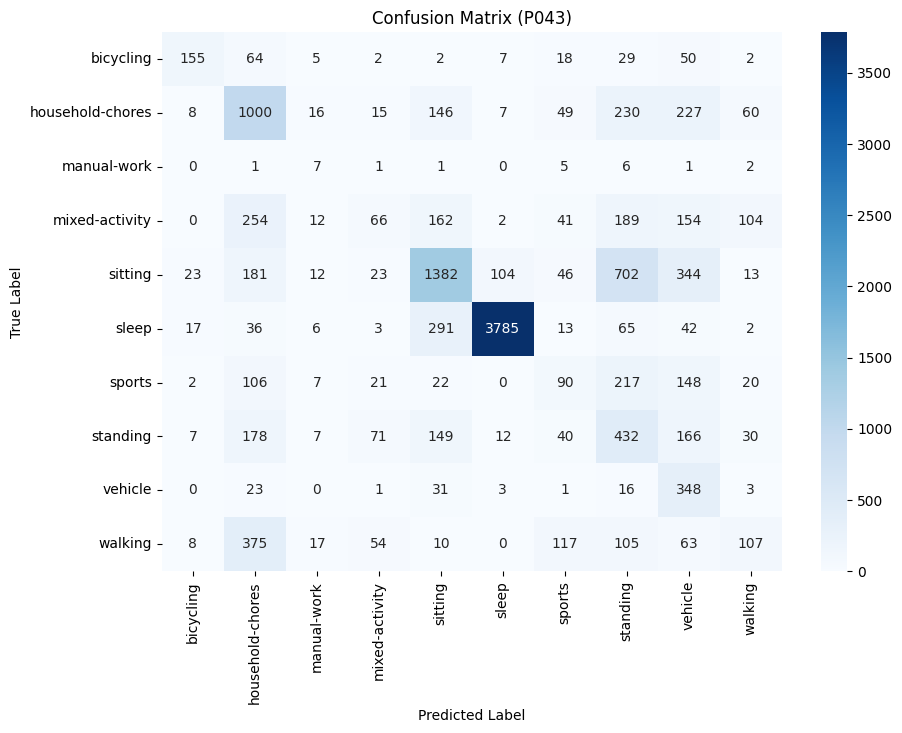

In [38]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (P043)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Resumo dos resultados

In [39]:
summary = {
    "test_accuracy": float(test_accuracy),
    "test_loss": float(test_loss),
    "macro_f1": float(macro_f1),
    "f1_per_class": f1_named,
    "confusion_matrix": cm_df
}

In [40]:
print("=== Summary for Participant P043 ===\n")

print(f"Test Accuracy:   {summary['test_accuracy']:.4f}")
print(f"Test Loss:       {summary['test_loss']:.4f}")
print(f"Macro F1:        {summary['macro_f1']:.4f}\n")

print("F1 per class:")
for label, value in summary["f1_per_class"].items():
    print(f"  {label:20s} {value:.4f}")

print("\nConfusion Matrix:")
display(summary["confusion_matrix"])

=== Summary for Participant P043 ===

Test Accuracy:   0.5586
Test Loss:       1.4382
Macro F1:        0.3751

F1 per class:
  bicycling            0.5596
  household-chores     0.5030
  manual-work          0.1239
  mixed-activity       0.1064
  sitting              0.5499
  sleep                0.9254
  sports               0.1709
  standing             0.2802
  vehicle              0.3535
  walking              0.1785

Confusion Matrix:


,bicycling,household-chores,manual-work,mixed-activity,sitting,sleep,sports,standing,vehicle,walking
bicycling,155,64,5,2,2,7,18,29,50,2
household-chores,8,1000,16,15,146,7,49,230,227,60
manual-work,0,1,7,1,1,0,5,6,1,2
mixed-activity,0,254,12,66,162,2,41,189,154,104
sitting,23,181,12,23,1382,104,46,702,344,13
sleep,17,36,6,3,291,3785,13,65,42,2
sports,2,106,7,21,22,0,90,217,148,20
standing,7,178,7,71,149,12,40,432,166,30
vehicle,0,23,0,1,31,3,1,16,348,3
walking,8,375,17,54,10,0,117,105,63,107


In [ ]:
model.save('/content/drive/MyDrive/capture24/models/mlp_v1_p043.keras')
